In [1]:
import os
import SimpleITK as sitk
import glob
import monai
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    AddChanneld,
    SpatialPadd,
    RandRotate90d,
    RandShiftIntensityd,
    EnsureTyped,
    EnsureType,
    MapTransform,
    Resized,
    Invertd,
    ToTensord,
    NormalizeIntensityd,
    RandFlipd,
    Lambdad,
    Activations,
    AsDiscrete,
)
from monai.metrics import ROCAUCMetric
from monai.data import CacheDataset, ThreadDataLoader,DataLoader, Dataset, decollate_batch,load_decathlon_datalist
import torch
from monai.utils import first, set_determinism
import torch.nn as  nn
from torch.nn import Linear,  Softmax
import torch.nn.functional as F
import pandas as pd
from sklearn import metrics
torch.multiprocessing.set_sharing_strategy('file_system')

In [2]:
model_dir = '/app/liucd/deeplearn_dec/DL_multi/NewTrain2Val3/net_selfattn/attn_concat/pretrain'

In [3]:
df_raw = pd.read_csv('/app/liucd/判定_fill_df.csv')
df_cli = df_raw[['patient_ID', 'T_stage', 'HER2_status', 'NAC_classification', 'ER_percentage', 'PR_percentage', 'Ki_67']]


In [4]:

sd_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/shandong/Mixed'
yizhong_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/yizhong/Mixed'
xian_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/xian/Mixed'


sd_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/shandong/Mixed'
yizhong_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/yizhong/Mixed'
xian_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/xian/Mixed'

val_adcimages =  sorted(glob.glob(os.path.join(sd_adcdir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(yizhong_adcdir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(xian_adcdir,  '*.nii.gz'))) 

val_dceimages =  sorted(glob.glob(os.path.join(sd_dcedir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(yizhong_dcedir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(xian_dcedir,  '*.nii.gz'))) 


val_clinical = []
for file_path in val_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    val_clinical.append(clinical_data)

val_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, clinical in zip(val_adcimages, val_dceimages, val_clinical)]

print(val_dict[-1])
print(len(val_dict))

{'image_adc': '/app/liucd/deeplearn_dec/DL_dec/data_adc/xian/Mixed/236_1412879_ADC2_0000_0.nii.gz', 'image_dce': '/app/liucd/deeplearn_dec/DL_dec/data/xian/Mixed/236_1412879_+C2_0000_0.nii.gz', 'clinical': [1.0, 0.0, 2.0, 0.0, 0.0, 0.7], 'label': 0}
619


In [13]:
val_transforms = Compose(
        [
            LoadImaged(keys=["image_adc",'image_dce' ]),
            EnsureChannelFirstd(keys=["image_adc", 'image_dce']),
            Orientationd(keys=["image_adc",'image_dce'], axcodes="RAS"),
            Resized(keys=["image_adc"], spatial_size=(64, 64, 16)),
            Resized(keys=["image_dce"], spatial_size=(96, 96, 32)),
            
            NormalizeIntensityd(keys=["image_adc", 'image_dce'], nonzero=True, channel_wise=True),
            ToTensord(keys=['image_adc', 'image_dce','clinical', 'label'])
        ]
    )


val_ds = Dataset(data=val_dict, transform=val_transforms)

# create a validation data loader
val_loader = DataLoader(val_ds, batch_size=1, num_workers=16, pin_memory=True)

In [14]:

class DoubleTower(nn.Module):
    def __init__(self,
                 pretrained_dce='',
                 pretrained_adc='',
                 device = torch.device("cuda"),
                 num_classes=2,
                 fc_hidden_size = 256
                ):
        super().__init__()
        self.pretrained_dce = pretrained_dce
        self.pretrained_adc = pretrained_adc
        self.fc_hidden_size = fc_hidden_size
        self.num_classes = num_classes
        self.device = device

        self.model_dce = monai.networks.nets.resnet18(spatial_dims=3, n_input_channels=1, num_classes=2, feed_forward=False).to(self.device)
        self.model_adc = monai.networks.nets.resnet18(spatial_dims=3, n_input_channels=1, num_classes=2, feed_forward=False).to(self.device)

        if  pretrained_dce != '':
            dce_dict = self.model_dce.state_dict()
            dce_pretrain = torch.load(self.pretrained_dce, map_location=self.device)
            dce_pretrain_dict = {k:v for k, v in dce_pretrain.items() if  k in  dce_dict.keys()}
            dce_dict.update(dce_pretrain_dict)
            self.model_dce.load_state_dict(dce_dict)

        if  pretrained_adc !='':
            adc_dict = self.model_adc.state_dict()
            adc_pretrain = torch.load(self.pretrained_adc, map_location=self.device)
            adc_pretrain_dict = {k:v for k, v in adc_pretrain.items() if  k in  adc_dict.keys()}
            adc_dict.update(adc_pretrain_dict)
            self.model_adc.load_state_dict(adc_dict)

        self.attn = nn.MultiheadAttention(512, num_heads=1, batch_first=True, device=self.device)

        # self.Linear1 = Linear(1024 + 6, self.num_classes, device=self.device)
        self.Linear1 = Linear(512, self.fc_hidden_size, device=self.device)  # 1024 是 所有下采样特征图globalpool之后拼接的结果
        self.Linear2 = Linear(self.fc_hidden_size + 6, self.num_classes, device=self.device)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x1, x2, structured_data):  # x 是SegResNet的输入影像矩阵

        encode_output1 = self.model_dce(x1)
        encode_output2 = self.model_dce(x2)

        concatenated = encode_output1 * encode_output2

        concatenated = concatenated.unsqueeze(1)
        attn_output, _ = self.attn(concatenated, concatenated, concatenated)

        attn_output = attn_output.squeeze(1)

        fc1 = F.relu(self.Linear1(attn_output))
        fc1 = self.dropout(fc1)


        fc2 = self.Linear2( torch.concat([fc1, structured_data], dim=-1))
        return F.log_softmax(fc2, dim=-1)


In [15]:

# dce_pretrain_path = ''
# adc_pretrain_path = ''

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = DoubleTower(device = device)

pretrained_path = os.path.join(model_dir, 'best_metric_model_classification3d_dict.pth')
model.load_state_dict(torch.load(pretrained_path, map_location=device))


<All keys matched successfully>

In [58]:
def report_metric(label_list, pred_list):
    Cmatrix = metrics.confusion_matrix(label_list, pred_list)
    # print(Cmatrix)
    TN = Cmatrix[0, 0]
    TP = Cmatrix[1, 1]
    FN = Cmatrix[1, 0]
    FP = Cmatrix[0, 1]

    Acc = (TP+TN) / (TP+TN+FP+FN)
    sensitivity = TPR = Recall = TP / (TP+FN)
    specificity = TNR =  TN / (FP+TN)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    
    return Acc, sensitivity, specificity, PPV, NPV

In [18]:
post_pred = Compose([Activations(softmax=True)])
post_label = Compose([AsDiscrete(to_onehot=2)])

auc_metric = ROCAUCMetric()

prob_list = []
label_list = []

model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for val_data in val_loader:

        val_dce, val_adc, val_clinical, val_labels = val_data["image_dce"].to(device),val_data["image_adc"].to(device), val_data["clinical"].to(device), val_data["label"].to(device)
        val_output = model(val_dce, val_adc, val_clinical)
         
        # sklearn
        prob_list.append(post_pred(val_output[0])[1].item())  # [0] 是由于设置batch=1 [1] 是是取预测类别中的1类别
        label_list.append(val_labels.item())
        
#         # monai
#         y_pred = torch.cat([y_pred, val_output], dim=0)
#         y = torch.cat([y, val_labels], dim=0)
        
#         y_onehot = [post_label(i) for i in decollate_batch(y, detach=False)]
#         y_pred_act = [post_pred(i) for i in decollate_batch(y_pred)]

# # sklearn
pred_list = [round(i) for i in prob_list]
Acc, sensitivity, specificity, PPV, NPV = report_metric(label_list, pred_list)
print('Accuray:', Acc)
print('SEN/SPE:', sensitivity, specificity)
print('PPV/NPV: ', PPV, NPV)

fpr, tpr, thresholds = metrics.roc_curve(label_list, prob_list, pos_label=1)
print(metrics.auc(fpr, tpr))

# # # monai
# auc_metric(y_pred_act, y_onehot)
# print(auc_metric.aggregate())

# acc_value = torch.eq(y_pred.argmax(dim=1), y)
# acc_metric = acc_value.sum().item() / len(acc_value)
# print(acc_metric)

[[374  51]
 [ 77 117]]
Accuray: 0.7932148626817448
SEN/SPE: 0.6030927835051546 0.88
PPV/NPV:  0.6964285714285714 0.8292682926829268
0.8508186779866587


In [ ]:
Accuray: 0.7932148626817448
SEN/SPE: 0.6030927835051546 0.88
PPV/NPV:  0.6964285714285714 0.8292682926829268
0.8508186779866587

In [20]:
len(label_list), sum(label_list)

(619, 194)

0.8045234248788369


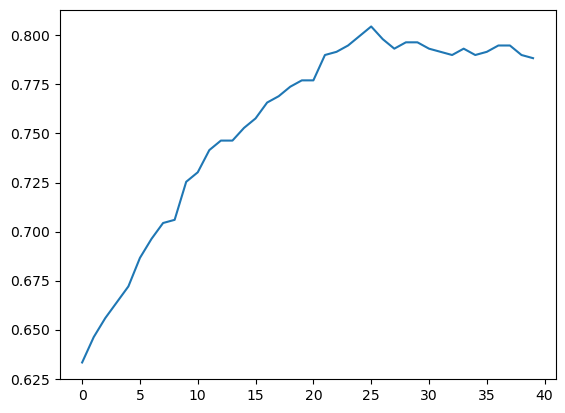

In [63]:
import matplotlib.pyplot as plt
def fun(x, threshold):
    if x > threshold:
        return 1
    else:
        return 0

Acc_list = []
for th in [ i/ 100 for i in list(range(20, 60)) ]:
    pred_list = [fun(i, th) for i in prob_list]
    Acc, sensitivity, specificity, PPV, NPV = report_metric(label_list, pred_list)
    Acc_list.append(Acc)
print(max(Acc_list))
plt.plot(Acc_list)

In [ ]:
fun(x)